# Simple experiments with simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pandas import read_csv, DataFrame, Series
import pandas as pd
from helper import *
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import poisson
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

## 1. Class plays no role (beta0 remains the same across classes)

In [2]:
samples = read_csv('rnaseq_class_plays_no_role.csv')
# leave only OT_ and CR_ patients
drop_list = []

for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
# genes = samples.index.values.to_list()
samples = samples.drop(drop_list[0:],axis=1)

In [3]:
# recode patient status to numeric (OT = 0, CR = 1)
patients = samples.columns[0:]
patients_labels = pd.DataFrame({'status':  [p[:2] for p in patients]})
print('Patients amount: \n', patients_labels.value_counts())

patients_labels = patients_labels.replace({'OT':0, 'CR':1})
labels = ['OT', 'CR']

Patients amount: 
 status
OT        20
CR        20
dtype: int64


In [4]:
rnaseq = samples.copy()
# transpose
samples = samples.transpose()
samples = samples.reset_index(drop=True)
samples.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,6,133,7,0,6,22,7,10,0,18,...,22,6,4,10,4,40,5,1,5,49
1,14,156,12,5,8,21,5,6,3,15,...,20,2,5,16,2,40,4,2,1,52
2,14,171,5,2,11,13,10,12,5,15,...,27,9,3,18,2,79,11,3,8,134
3,10,151,9,6,19,19,4,9,1,11,...,37,6,8,10,3,50,4,1,4,54
4,10,178,13,6,16,16,6,8,2,6,...,23,8,3,13,4,73,13,2,7,130


In [5]:
# normalize data for logistic regression
# X = StandardScaler().fit_transform(samples)
X = samples
y = patients_labels
X = pd.DataFrame(data=X, columns=samples.columns)

In [6]:
n_splits = 5
genes_range = [3, 5, 10, 20] # number of selected genes
results = dict((k, np.array([]).reshape((0,3))) for k in genes_range)
signatures = dict((k, dict()) for k in genes_range)
selected_features = dict((k, dict()) for k in genes_range)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=30).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            auc_scores.append(auc)

            if name != 'Random':
                sgntr = tuple(genes)
                signatures[selected_k][sgntr] = selected_features[selected_k][sgntr] + 1 if sgntr in selected_features[selected_k] else 1
                for g in genes:
                    selected_features[selected_k][g] = selected_features[selected_k][g] + 1 if g in selected_features[selected_k] else 1

        # print(np.array(auc_scores))
        results[selected_k] = np.vstack((results[selected_k], np.array(auc_scores)))

    if i % 5 == 0:
        for k_ind, genes in results.items():
            mean_auc = np.mean(results[k_ind][-n_splits:, :], axis=0)
            results[k_ind] = np.vstack((results[k_ind][:-n_splits, :], mean_auc))

##### Show how IS misleads the CR/OT classifier (the classification accuracy should be 50% but will be higher due to IS)

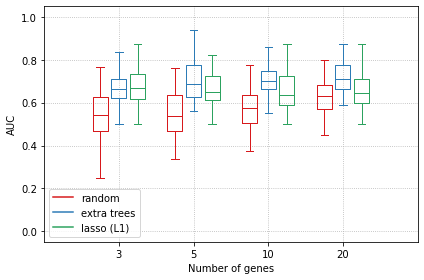

In [7]:
# show boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups1 = group_data(results)
show_cv(data_groups1, genes_range, methods_names)

##### Compensate for IS (learn from STA, apply to CR), find params when the compensation works

In [8]:
t = 100
samples = pd.read_csv('rnaseq_class_plays_no_role.csv', index_col=0)
IS = pd.read_csv('IS_class_plays_no_role.csv', index_col=0)

In [9]:
drop_list = []
for patient in samples.columns:
    if patient[:3] != 'STA':
        drop_list.append(patient)
STA_counts = samples.drop(drop_list, axis=1).to_numpy()
STA_IS = IS.drop(drop_list, axis=0)

In [10]:
# try to learn the beta1 parameters from STA class
learned_beta1 = np.zeros(t)
for ind in range(t):
    df = pd.DataFrame({"x": STA_IS['IS1'].values.tolist(),
                       "y": STA_counts[ind]})
    mp = sm.formula.glm("y ~ x", family=sm.families.Poisson(), data=df).fit()
    learned_beta1[ind] = mp.params.x

In [11]:
# leave only CR OT classes for classification
drop_list = []
for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
OT_CR_counts = samples.drop(drop_list, axis=1).to_numpy(dtype=float)
OT_CR_IS = IS.drop(drop_list)['IS1'].values

In [12]:
# filter the IS1 out from the CR count data
for ind in range(t):
    OT_CR_counts[ind, :20] = OT_CR_counts[ind, :20]/np.exp(OT_CR_IS[:20] * learned_beta1[ind])

In [13]:
# normalize data for logistic regression
OT_CR_counts = OT_CR_counts.transpose()
X = StandardScaler().fit_transform(OT_CR_counts)
y = patients_labels
X = pd.DataFrame(data=X, columns=samples.index)

In [14]:
n_splits = 5
genes_range = [3, 5, 10, 20] # number of selected genes
results = dict((k, np.array([]).reshape((0,3))) for k in genes_range)
signatures = dict((k, dict()) for k in genes_range)
selected_features = dict((k, dict()) for k in genes_range)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=30).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            auc_scores.append(auc)

            # if name != 'Random':
            #     sgntr = tuple(genes)
            #     signatures[selected_k][sgntr] = selected_features[selected_k][sgntr] + 1 if sgntr in selected_features[selected_k] else 1
            #     for g in genes:
            #         selected_features[selected_k][g] = selected_features[selected_k][g] + 1 if g in selected_features[selected_k] else 1
        # print(results[selected_k].reshape((0,3)))
        # print(np.array(auc_scores))
        results[selected_k] = np.vstack((results[selected_k], np.array(auc_scores)))

    if i % 5 == 0:
        for k_ind, genes in results.items():
            mean_auc = np.mean(results[k_ind][-n_splits:, :], axis=0)
            results[k_ind] = np.vstack((results[k_ind][:-n_splits, :], mean_auc))


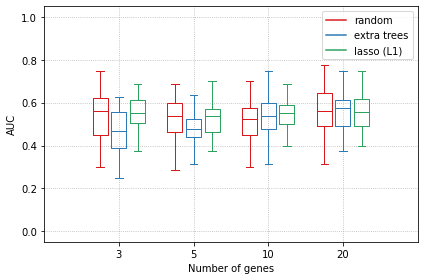

In [15]:
# modify data for boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups2 = group_data(results)

# show boxplots
show_cv(data_groups2, genes_range, methods_names)

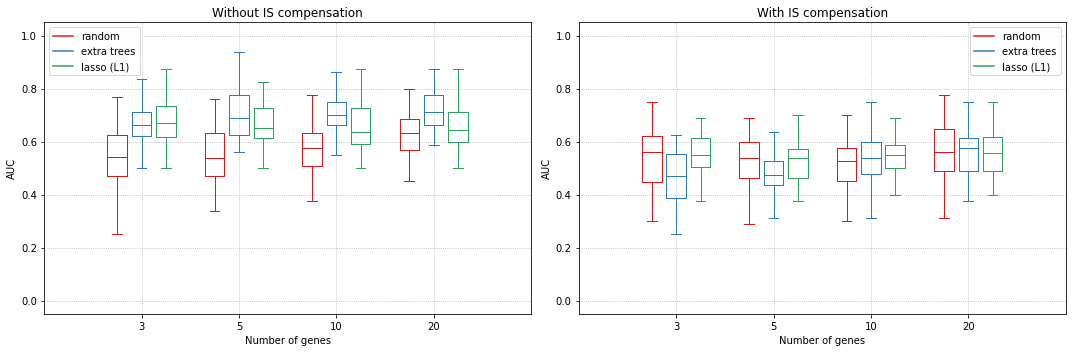

In [16]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
show_cv(data_groups1, genes_range, methods_names)
plt.title("Without IS compensation")

plt.subplot(1, 2, 2)
show_cv(data_groups2, genes_range, methods_names)
plt.title("With IS compensation")

plt.savefig("Classification_class_plays_no_role.png")
plt.show()



## 2. Class plays role

In [17]:
samples = read_csv('rnaseq_class_plays_role.csv')
# leave only OT_ and CR_ patients
drop_list = []

for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
# genes = samples.index.values.to_list()
samples = samples.drop(drop_list[0:],axis=1)

In [18]:
# recode patient status to numeric (OT = 0, CR = 1)
patients = samples.columns[0:]
patients_labels = pd.DataFrame({'status':  [p[:2] for p in patients]})
print('Patients amount: \n', patients_labels.value_counts())

patients_labels = patients_labels.replace({'OT':0, 'CR':1})
labels = ['OT', 'CR']

Patients amount: 
 status
OT        20
CR        20
dtype: int64


In [19]:
rnaseq = samples.copy()
# transpose
samples = samples.transpose()
samples = samples.reset_index(drop=True)
samples.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,22,9,9,100,5,3,13,25,3,10,...,8,21,4,15,1,30,47,12,3,47
1,18,9,8,113,10,9,17,34,6,14,...,4,17,9,11,0,16,23,7,4,25
2,24,8,11,113,7,2,5,38,2,9,...,7,17,7,5,0,16,26,9,1,28
3,20,13,9,106,5,1,8,30,4,7,...,7,10,9,8,0,10,21,3,3,21
4,22,11,9,106,5,5,13,35,6,11,...,4,15,14,7,0,16,34,3,5,22


In [20]:
# normalize data for logistic regression
X = StandardScaler().fit_transform(samples)
y = patients_labels
X = pd.DataFrame(data=X, columns=samples.columns)

In [21]:
n_splits = 5
genes_range = [3, 5, 10, 20] # number of selected genes
results = dict((k, np.array([]).reshape((0,3))) for k in genes_range)
signatures = dict((k, dict()) for k in genes_range)
selected_features = dict((k, dict()) for k in genes_range)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=30).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            auc_scores.append(auc)

            if name != 'Random':
                sgntr = tuple(genes)
                signatures[selected_k][sgntr] = selected_features[selected_k][sgntr] + 1 if sgntr in selected_features[selected_k] else 1
                for g in genes:
                    selected_features[selected_k][g] = selected_features[selected_k][g] + 1 if g in selected_features[selected_k] else 1

        # print(np.array(auc_scores))
        results[selected_k] = np.vstack((results[selected_k], np.array(auc_scores)))

    if i % 5 == 0:
        for k_ind, genes in results.items():
            mean_auc = np.mean(results[k_ind][-n_splits:, :], axis=0)
            results[k_ind] = np.vstack((results[k_ind][:-n_splits, :], mean_auc))

##### Show how IS (falsely) increases the classification accuracy

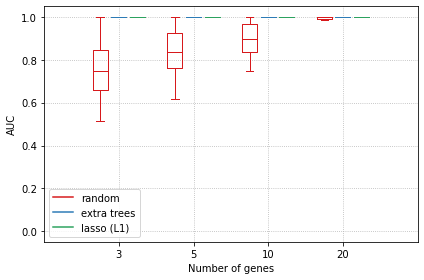

In [22]:
# show boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups3 = group_data(results)
show_cv(data_groups3, genes_range, methods_names)

##### Compensate for IS (learn from STA, apply to CR), find params when the compensation works

In [23]:
t = 100
samples = pd.read_csv('rnaseq_class_plays_role.csv', index_col=0)
IS = pd.read_csv('IS_class_plays_role.csv', index_col=0)

In [24]:
# leave only STA
drop_list = []
for patient in samples.columns:
    if patient[:3] != 'STA':
        drop_list.append(patient)
STA_counts = samples.drop(drop_list, axis=1).to_numpy()
STA_IS = IS.drop(drop_list, axis=0)

In [25]:
# try to learn the beta1 parameters from STA class
learned_beta1 = np.zeros(t)
for ind in range(t):
    df = pd.DataFrame({"x": STA_IS['IS1'].values.tolist(),
                       "y": STA_counts[ind]})
    mp = sm.formula.glm("y ~ x", family=sm.families.Poisson(), data=df).fit()
    learned_beta1[ind] = mp.params.x

In [26]:
# leave only CR and OT classes for classification
drop_list = []
for patient in samples.columns:
    if patient[:2] != 'OT' and patient[:2] != 'CR':
        drop_list.append(patient)
OT_CR_counts = samples.drop(drop_list, axis=1).to_numpy(dtype=float)
OT_CR_IS = IS.drop(drop_list)['IS1'].values

In [27]:
# filter the IS1 out from the CR count data
for ind in range(t):
    # print(np.exp(OT_CR_IS[:20] * learned_beta1[ind]))
    OT_CR_counts[ind, :20] = OT_CR_counts[ind, :20]/np.exp(OT_CR_IS[:20] * learned_beta1[ind]) # first 20 is CR

In [28]:
# normalize data for logistic regression
OT_CR_counts = OT_CR_counts.transpose()
X = StandardScaler().fit_transform(OT_CR_counts)
# X = OT_CR_counts
y = patients_labels
X = pd.DataFrame(data=X, columns=samples.index)

In [29]:
n_splits = 5
genes_range = [3, 5, 10, 20] # number of selected genes
results = dict((k, np.array([]).reshape((0,3))) for k in genes_range)
signatures = dict((k, dict()) for k in genes_range)
selected_features = dict((k, dict()) for k in genes_range)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=30).split(X, y)
for i, (train_idx, test_idx) in enumerate(cv):
    X_train, y_train = [X.iloc[train_idx, :], y.iloc[train_idx]]
    X_test, y_test = [X.iloc[test_idx, :], y.iloc[test_idx]]

    for selected_k in genes_range:
        # print('\nNumber of genes: ', selected_k)

        # feature selection
        selected_genes = dict()
        selected_genes['Random'] = feature_selection_random(X_train, selected_k)
        selected_genes['Extra trees'] = feature_selection_extra_trees(X_train, y_train.values.ravel(), selected_k)
        selected_genes['Lasso'] = feature_selection_l1(X_train, y_train.values.ravel(), selected_k)

        auc_scores = []
        for name, genes in selected_genes.items():
            X_train_selected = X_train[genes]
            X_test_selected = X_test[genes]

            # model prediction
            model = LogisticRegression(solver='liblinear', penalty='l1').fit(X_train_selected, y_train.values.ravel())
            probabilities = model.predict_proba(X_test_selected)[:, 1]

            # calculate auroc score
            auc = roc_auc_score(y_test, probabilities)
            auc_scores.append(auc)

        results[selected_k] = np.vstack((results[selected_k], np.array(auc_scores)))

    if i % 5 == 0:
        for k_ind, genes in results.items():
            mean_auc = np.mean(results[k_ind][-n_splits:, :], axis=0)
            results[k_ind] = np.vstack((results[k_ind][:-n_splits, :], mean_auc))

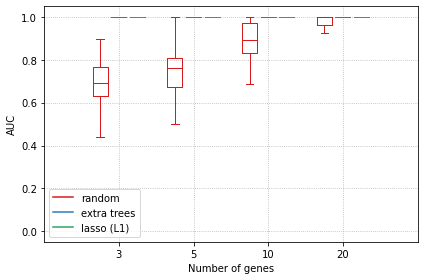

In [30]:
# modify data for boxplots
methods_names = ['random', 'extra trees', 'lasso (L1)']
data_groups4 = group_data(results)

# show boxplots
show_cv(data_groups4, genes_range, methods_names)

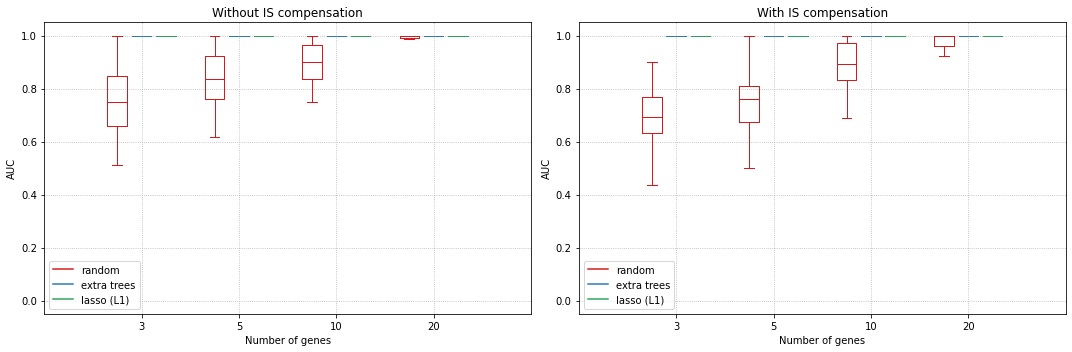

In [31]:
fig = plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
show_cv(data_groups3, genes_range, methods_names)
plt.title("Without IS compensation")

plt.subplot(1, 2, 2)
show_cv(data_groups4, genes_range, methods_names)
plt.title("With IS compensation")

plt.savefig("Classification_class_plays_role.png")
plt.show()